In [19]:
import pandas as pd
import numpy as np
import shap
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load the DataFrame
df = pd.read_csv("imputed_covid_data_m2_modified.csv")

# Step 1: Scale AGE
scaler = StandardScaler()
df['AGE_scaled'] = scaler.fit_transform(df[['AGE']])
df = df.drop(columns=['AGE'])

# Step 2: Apply LabelEncoder to all other columns
le = LabelEncoder()
for col in df.columns:
    if col != 'AGE_scaled':
        df[col] = le.fit_transform(df[col])

# Step 3: Train-test split
working_df, valid_df = train_test_split(df, test_size=0.20, random_state=42)

# Step 4: Save the encoded and split data
working_df.to_csv("working_encoded.csv", index=False)
valid_df.to_csv("valid_encoded.csv", index=False)

In [20]:
working_df = pd.read_csv("working_encoded.csv")

In [21]:
# ---------- 1. Model for ICU ----------
icu_df = working_df.drop(columns=['INTUBED'], errors='ignore')
icu_df = working_df.dropna()
icu_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189220 entries, 0 to 189219
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   USMER           189220 non-null  int64  
 1   SEX             189220 non-null  int64  
 2   PATIENT_TYPE    189220 non-null  int64  
 3   INTUBED         189220 non-null  int64  
 4   PNEUMONIA       189220 non-null  int64  
 5   DIABETES        189220 non-null  int64  
 6   COPD            189220 non-null  int64  
 7   ASTHMA          189220 non-null  int64  
 8   INMSUPR         189220 non-null  int64  
 9   HIPERTENSION    189220 non-null  int64  
 10  OTHER_DISEASE   189220 non-null  int64  
 11  CARDIOVASCULAR  189220 non-null  int64  
 12  OBESITY         189220 non-null  int64  
 13  RENAL_CHRONIC   189220 non-null  int64  
 14  TOBACCO         189220 non-null  int64  
 15  ICU             189220 non-null  int64  
 16  DIED            189220 non-null  int64  
 17  COVID_stat

In [22]:
icu_df['ICU'].value_counts()

ICU
0    176216
1     13004
Name: count, dtype: int64

In [23]:
# Separate features and target
X = icu_df.drop(columns=['ICU', 'INTUBED'])
y = icu_df['ICU']

# Apply SMOTE for balancing the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Combine resampled data into a new DataFrame
icu_resampled = pd.DataFrame(X_resampled, columns=X.columns)
icu_resampled['ICU'] = y_resampled

# Check the class distribution after SMOTE
print(icu_resampled['ICU'].value_counts())

ICU
0    176216
1    176216
Name: count, dtype: int64


In [20]:
icu_resampled.columns

Index(['USMER', 'SEX', 'PATIENT_TYPE', 'PNEUMONIA', 'DIABETES', 'COPD',
       'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR',
       'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'DIED', 'COVID_status',
       'AGE_scaled', 'ICU'],
      dtype='object')

In [24]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=123
)


In [25]:
from sklearn.tree import DecisionTreeClassifier

# Initialize and train the model with the specified parameters
dt_model = DecisionTreeClassifier(
    ccp_alpha=0.0,
    class_weight=None,
    criterion='gini',
    max_depth=None,
    max_features=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_samples_leaf=1,
    min_samples_split=2,
    min_weight_fraction_leaf=0.0,
    monotonic_cst=None,
    random_state=123,
    splitter='best'
)

# Train the model
dt_model.fit(X_train, y_train)

# Predict on test set
y_pred = dt_model.predict(X_test)


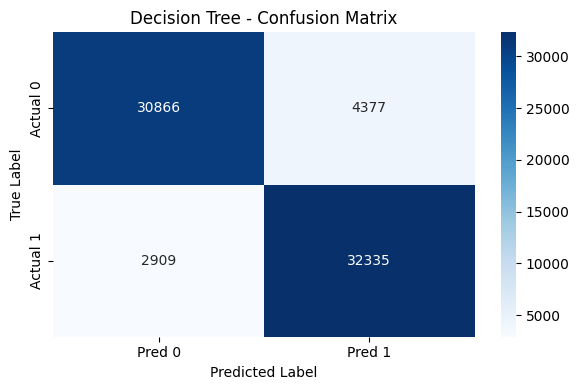

Accuracy: 0.8966
F1 Score: 0.8987
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89     35243
           1       0.88      0.92      0.90     35244

    accuracy                           0.90     70487
   macro avg       0.90      0.90      0.90     70487
weighted avg       0.90      0.90      0.90     70487



In [26]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 0', 'Pred 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Decision Tree - Confusion Matrix')
plt.tight_layout()
plt.show()

# Compute Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# F1 Score
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")

# Full classification report (Precision, Recall, F1-score, Support for each class)
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)


In [27]:
# Step 1: Save the trained model
joblib.dump(dt_model, 'decision_tree_icu_model.pkl')

['decision_tree_icu_model.pkl']

In [28]:
# Step 2: Load the model
loaded_model = joblib.load('decision_tree_icu_model.pkl')

In [29]:
valid_df = pd.read_csv("valid_encoded.csv")

In [26]:
# Drop the 'INTUBED' column from the validation dataset
valid_df_icu = valid_df.drop(columns=['INTUBED'], errors='ignore')
valid_df_icu = valid_df_icu.dropna()


In [15]:
valid_df_icu.columns

Index(['USMER', 'SEX', 'PATIENT_TYPE', 'PNEUMONIA', 'DIABETES', 'COPD',
       'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR',
       'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'ICU', 'DIED', 'COVID_status',
       'AGE_scaled'],
      dtype='object')

F1 Score: 0.23901015994366764


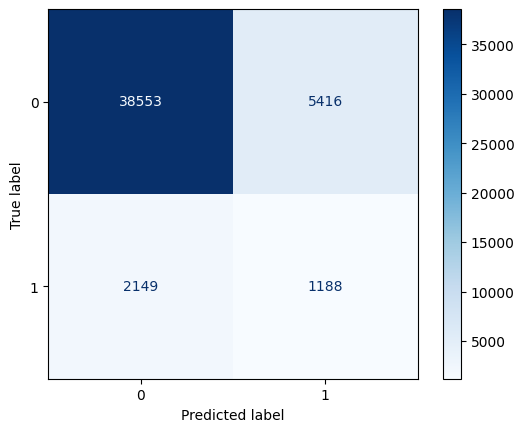

In [30]:

# Separate features and target for validation data
X_valid = valid_df_icu.drop(columns=['ICU'])
y_valid = valid_df_icu['ICU']

# Use the trained model to make predictions
y_pred = loaded_model.predict(X_valid)


# Compute confusion matrix and F1 score
from sklearn.metrics import confusion_matrix, f1_score
cm = confusion_matrix(y_valid, y_pred)
f1 = f1_score(y_valid, y_pred)

# Print F1 score
print("F1 Score:", f1)

# Plot confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt_model.classes_)
disp.plot(cmap='Blues')

Accuracy: 0.8578
F1 Score: 0.8578
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86     43969
           1       0.87      0.84      0.86     43969

    accuracy                           0.86     87938
   macro avg       0.86      0.86      0.86     87938
weighted avg       0.86      0.86      0.86     87938



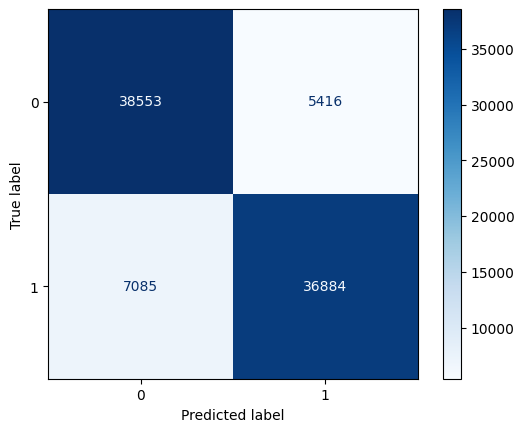

In [31]:
# validation after oversampling:

# Load the pre-trained model
loaded_model = joblib.load('decision_tree_icu_model.pkl')

# Read the validation data
valid_df = pd.read_csv("valid_encoded.csv")

# Drop the 'INTUBED' column from the validation dataset
valid_df_icu = valid_df.drop(columns=['INTUBED'], errors='ignore')
valid_df_icu = valid_df_icu.dropna()  # Drop rows with missing values

# Separate features and target for validation data
X_valid = valid_df_icu.drop(columns=['ICU'])
y_valid = valid_df_icu['ICU']

# Apply SMOTE to the validation data (for balancing)
smote = SMOTE(random_state=42)

# Resample the validation data (X_valid, y_valid) using SMOTE
X_valid_resampled, y_valid_resampled = smote.fit_resample(X_valid, y_valid)

# Use the trained model to make predictions
y_pred = loaded_model.predict(X_valid_resampled)

# Confusion matrix
cm = confusion_matrix(y_valid_resampled, y_pred)

# Accuracy
accuracy = accuracy_score(y_valid_resampled, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# F1 Score
f1 = f1_score(y_valid_resampled, y_pred, average='weighted')  # use 'weighted' if multiclass
print(f"F1 Score: {f1:.4f}")

# Full Classification Report
report = classification_report(y_valid_resampled, y_pred)
print("Classification Report:")
print(report)

# Plot confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=loaded_model.classes_)
disp.plot(cmap='Blues')


In [32]:
# ---------- 2. Model for PATIENT_TYPE ----------
# Drop ICU, INTUBED and drop NaNs
ptype_df = working_df.drop(columns=['ICU', 'INTUBED'], errors='ignore').dropna()

In [33]:
ptype_df['PATIENT_TYPE'].value_counts()

PATIENT_TYPE
0    109251
1     79969
Name: count, dtype: int64

PATIENT_TYPE
1    109251
0    109251
Name: count, dtype: int64
[LightGBM] [Info] Number of positive: 87319, number of negative: 87482
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 293
[LightGBM] [Info] Number of data points in the train set: 174801, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499534 -> initscore=-0.001865
[LightGBM] [Info] Start training from score -0.001865


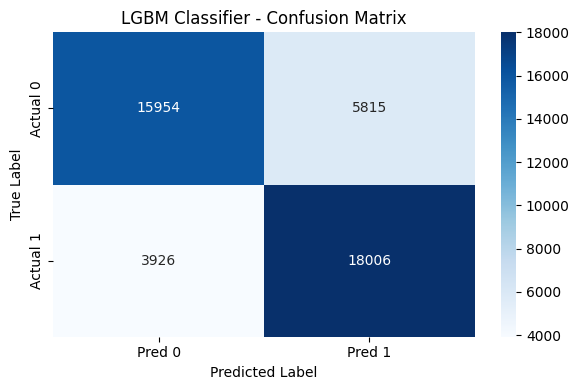

Accuracy: 0.7771
F1 Score: 0.7871
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.73      0.77     21769
           1       0.76      0.82      0.79     21932

    accuracy                           0.78     43701
   macro avg       0.78      0.78      0.78     43701
weighted avg       0.78      0.78      0.78     43701



In [34]:

# Drop 'ICU' and 'INTUBED' columns, and handle missing values
ptype_df = working_df.drop(columns=['ICU', 'INTUBED'], errors='ignore').dropna()

# Separate features and target
X_ptype = ptype_df.drop(columns=['PATIENT_TYPE'])  # Replace 'PATIENT_TYPE' with your actual target column name
y_ptype = ptype_df['PATIENT_TYPE']  # Adjust target column name if needed

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_ptype, y_ptype)

# Combine resampled data into a new DataFrame
ptype_resampled = pd.DataFrame(X_resampled, columns=X_ptype.columns)
ptype_resampled['PATIENT_TYPE'] = y_resampled

# Check the class distribution after SMOTE
print(ptype_resampled['PATIENT_TYPE'].value_counts())

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=123
)

# Initialize and train the model with the specified parameters (LGBMClassifier)
lgbm_model = LGBMClassifier(
    boosting_type='gbdt', 
    class_weight=None, 
    colsample_bytree=1.0,
    importance_type='split', 
    learning_rate=0.1, 
    max_depth=-1,
    min_child_samples=20, 
    min_child_weight=0.001, 
    min_split_gain=0.0,
    n_estimators=100, 
    n_jobs=-1, 
    num_leaves=31, 
    objective=None,
    random_state=123, 
    reg_alpha=0.0, 
    reg_lambda=0.0, 
    subsample=1.0, 
    subsample_for_bin=200000, 
    subsample_freq=0
)

# Train the model
lgbm_model.fit(X_train, y_train)

# Predict on the test set
y_pred = lgbm_model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 0', 'Pred 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('LGBM Classifier - Confusion Matrix')
plt.tight_layout()
plt.show()

# Compute Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# F1 Score
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")

# Full classification report (Precision, Recall, F1-score, Support for each class)
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

# Step 1: Save the trained model
joblib.dump(lgbm_model, 'L_ptype_model.pkl')

# Step 2: Load the model (example)
loaded_model = joblib.load('L_ptype_model.pkl')


In [35]:
valid_df = pd.read_csv("valid_encoded.csv")

In [36]:
# Drop the 'INTUBED' column from the validation dataset
valid_df_icu = valid_df.drop(columns=['INTUBED', 'ICU'], errors='ignore')
valid_df_icu = valid_df_icu.dropna()

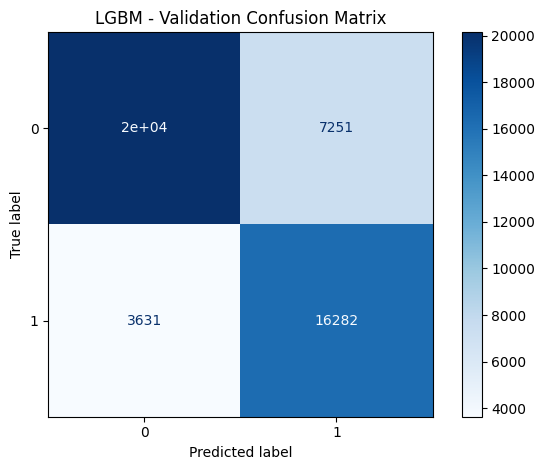

Accuracy: 0.7700
F1 Score: 0.7714
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.74      0.79     27393
           1       0.69      0.82      0.75     19913

    accuracy                           0.77     47306
   macro avg       0.77      0.78      0.77     47306
weighted avg       0.78      0.77      0.77     47306



In [37]:
# Load validation dataset (make sure it has the same preprocessing and encoding as training data)
valid_df_ptype = valid_df.drop(columns=['ICU', 'INTUBED'], errors='ignore').dropna()

# Separate features and target
X_valid = valid_df_ptype.drop(columns=['PATIENT_TYPE'])
y_valid = valid_df_ptype['PATIENT_TYPE']

# Load trained model
loaded_model_2 = joblib.load('L_ptype_model.pkl')

# Predict using the loaded model
y_pred = loaded_model_2.predict(X_valid)

# Confusion Matrix
cm = confusion_matrix(y_valid, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('LGBM - Validation Confusion Matrix')
plt.tight_layout()
plt.show()

# Accuracy
accuracy = accuracy_score(y_valid, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# F1 Score
f1 = f1_score(y_valid, y_pred, average='weighted')  # use 'weighted' if multiclass
print(f"F1 Score: {f1:.4f}")

# Full Classification Report
report = classification_report(y_valid, y_pred)
print("Classification Report:")
print(report)
